In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
chembl20 = pd.read_parquet("/scratch/work/masooda1/mocop/data/chembl20/chembl20.parquet")
chembl20 = chembl20.iloc[:,1:]

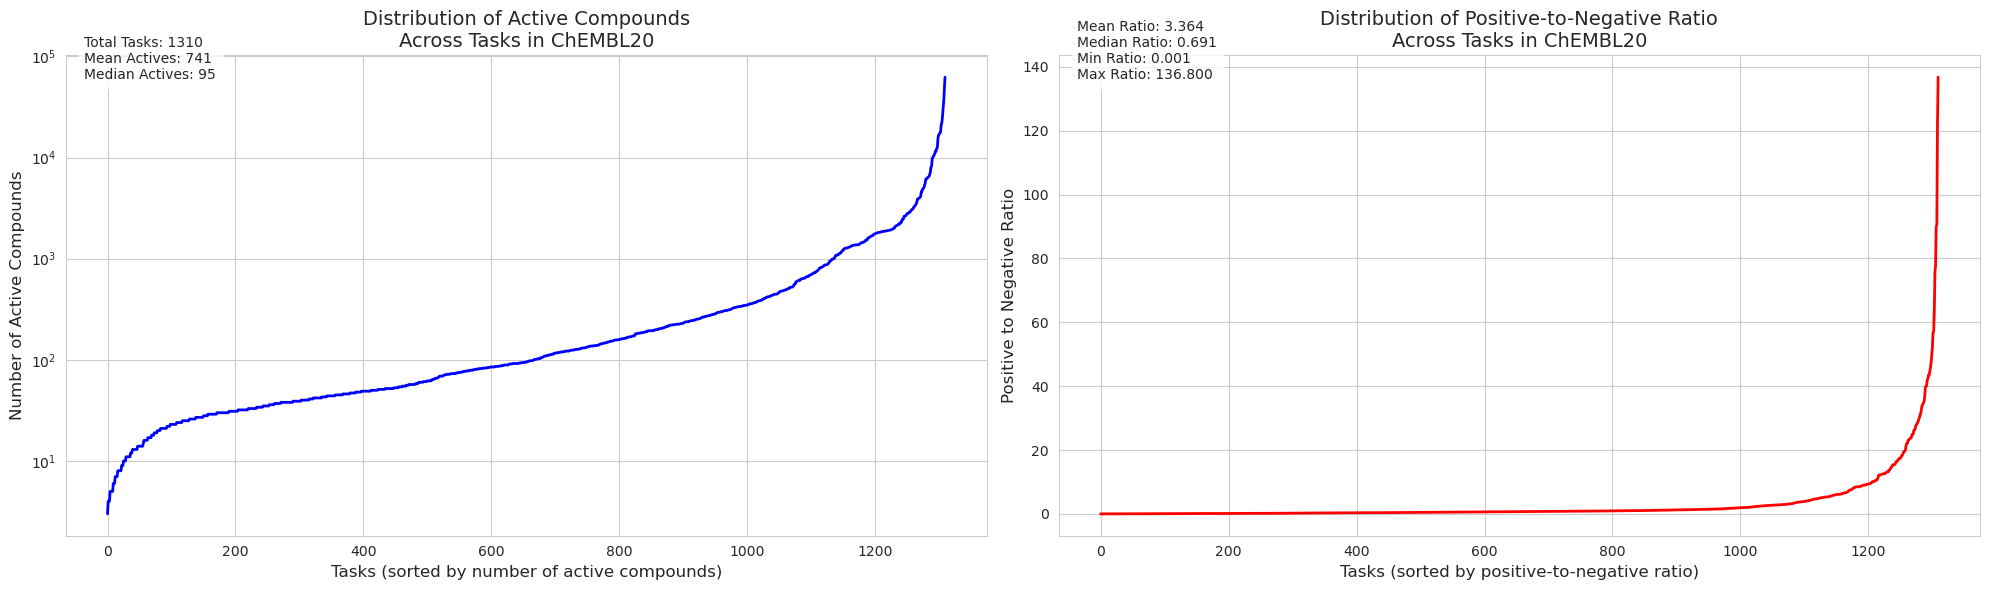


Active Compounds Statistics:
Min actives: 3
Max actives: 62268
Mean actives: 740.74
Median actives: 95.00

Positive-to-Negative Ratio Statistics:
Min ratio: 0.001
Max ratio: 136.800
Mean ratio: 3.364
Median ratio: 0.691


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate metrics
active_per_task = sorted((chembl20 == 1).sum())
pos_neg_ratio = (chembl20 == 1).sum() / (chembl20 == 0).sum()
pos_neg_ratio_sorted = sorted(pos_neg_ratio)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.set_style("whitegrid")

# Plot 1: Active Compounds Distribution
ax1.plot(range(len(active_per_task)), active_per_task, 
         color='blue', linewidth=2)
ax1.set_xlabel('Tasks (sorted by number of active compounds)', fontsize=12)
ax1.set_ylabel('Number of Active Compounds', fontsize=12)
ax1.set_title('Distribution of Active Compounds\nAcross Tasks in ChEMBL20', fontsize=14)
ax1.set_yscale("log")

# Add statistics to first plot
ax1.text(0.02, 0.95, 
         f'Total Tasks: {len(active_per_task)}\n'
         f'Mean Actives: {np.mean(active_per_task):.0f}\n'
         f'Median Actives: {np.median(active_per_task):.0f}',
         transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=10)

# Plot 2: Positive to Negative Ratio
ax2.plot(range(len(pos_neg_ratio_sorted)), pos_neg_ratio_sorted, 
         color='red', linewidth=2)
ax2.set_xlabel('Tasks (sorted by positive-to-negative ratio)', fontsize=12)
ax2.set_ylabel('Positive to Negative Ratio', fontsize=12)
ax2.set_title('Distribution of Positive-to-Negative Ratio\nAcross Tasks in ChEMBL20', fontsize=14)
ax1.set_yscale("symlog")

# Add statistics to second plot
ax2.text(0.02, 0.95, 
         f'Mean Ratio: {np.mean(pos_neg_ratio):.3f}\n'
         f'Median Ratio: {np.median(pos_neg_ratio):.3f}\n'
         f'Min Ratio: {min(pos_neg_ratio):.3f}\n'
         f'Max Ratio: {max(pos_neg_ratio):.3f}',
         transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=10)

# Adjust layout and save
plt.tight_layout()
plt.savefig('/scratch/work/masooda1/Results/Multimodal/mocop/chembl20_distribution_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print overall statistics
print("\nActive Compounds Statistics:")
print(f"Min actives: {min(active_per_task)}")
print(f"Max actives: {max(active_per_task)}")
print(f"Mean actives: {np.mean(active_per_task):.2f}")
print(f"Median actives: {np.median(active_per_task):.2f}")

print("\nPositive-to-Negative Ratio Statistics:")
print(f"Min ratio: {min(pos_neg_ratio):.3f}")
print(f"Max ratio: {max(pos_neg_ratio):.3f}")
print(f"Mean ratio: {np.mean(pos_neg_ratio):.3f}")
print(f"Median ratio: {np.median(pos_neg_ratio):.3f}")

In [2]:
def load_data(results_dir, model_name):
    all_data = []
    pattern = r"frac(\d+)_split(\d+)_seed(\d+)\.json"
    
    for filename in os.listdir(results_dir):
        if filename.endswith(".json"):
            match = re.match(pattern, filename)
            
            if match:
                frac, split, seed = match.groups()
                with open(os.path.join(results_dir, filename), 'r') as f:
                    data = json.load(f)
                new_data = {
                    'frac': int(frac),
                    'split': int(split),
                    'seed': int(seed),
                    'model': model_name
                }
                new_data.update(data)
                all_data.append(new_data)
    
    return pd.DataFrame(all_data)

In [ ]:
'/scratch/project_462000513/arslan/trained_model_pred/chembl_20_pretrained_mocop_all_cell_lines_lincs_linear_prob/chembl20_mocop_lincs_linear_frac1_split1_seed0/checkpoints/best_ckpt.ckpt'
'/scratch/project_462000513/arslan/trained_model_pred/chembl_20_pretrained_mocop_all_cell_lines_lincs_linear_prob/chembl20_mocop_lincs_linear_frac1_split1_seed0'


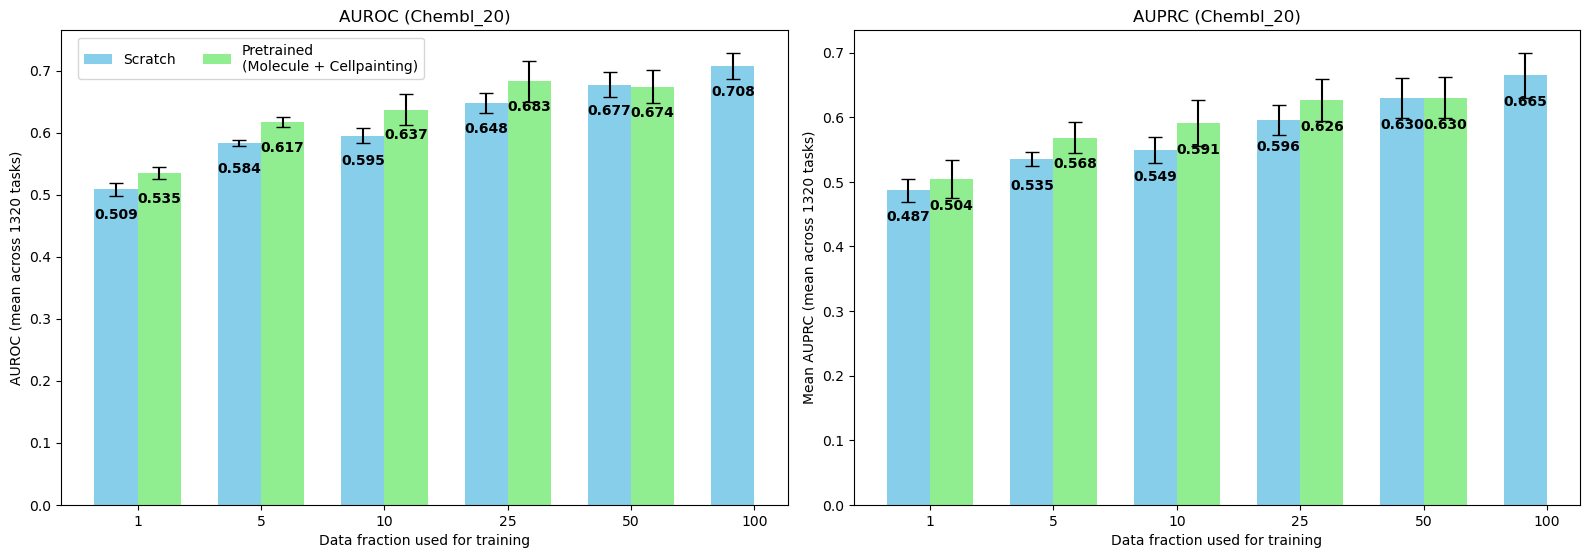

In [3]:
# Load data for both models
df1 = load_data("/scratch/work/masooda1/trained_model_pred/mocop/chembl20_from_scratch/test_results/chembl_20_from_scratch/", "Scratch")
df2 = load_data("/scratch/work/masooda1/trained_model_pred/mocop/chembl_20_pretrained_mocop_Aalto_linear_prob/test_results/chembl20_mocop_linear/", "Pretrained\n(Molecule + Cellpainting)")

# Combine the data
df = pd.concat([df1, df2])

# Calculate mean values and standard deviations
mean_values = df.groupby(['frac', 'model'])[['val/auroc_mean', 'val/auprc_mean']].mean().reset_index()
std_values = df.groupby(['frac', 'model'])[['val/auroc_mean', 'val/auprc_mean']].std().reset_index()

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define the order of models and their colors
model_order = ["Scratch", "Pretrained\n(Molecule + Cellpainting)"]
colors = ["skyblue", "lightgreen"]

# Function to plot bars and add text
def plot_bars(ax, data, y_col, title, ylabel):
    fracs = sorted(data['frac'].unique())
    x = np.arange(len(fracs))
    width = 0.35
    
    for i, (model, color) in enumerate(zip(model_order, colors)):
        model_data = data[data['model'] == model]
        means = [model_data[model_data['frac'] == frac][y_col].values[0] if frac in model_data['frac'].values else np.nan for frac in fracs]
        stds = [std_values[(std_values['frac'] == frac) & (std_values['model'] == model)][y_col].values[0] if frac in model_data['frac'].values else np.nan for frac in fracs]
        
        bars = ax.bar(x + (i-0.5)*width, means, width, label=model, yerr=stds, capsize=5, color=color)
        
        for j, (mean, std) in enumerate(zip(means, stds)):
            if not np.isnan(mean):
                ax.text(x[j] + (i-0.5)*width, mean - 0.03, f'{mean:.3f}', ha='center', va='top', fontweight='bold')  # Adjusted position

    ax.set_title(title)
    ax.set_xlabel('Data fraction used for training')
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(fracs)

# Plot AUROC
plot_bars(ax1, mean_values, 'val/auroc_mean', 'AUROC (Chembl_20)', 'AUROC (mean across 1320 tasks)')

# Plot AUPRC
plot_bars(ax2, mean_values, 'val/auprc_mean', 'AUPRC (Chembl_20)', 'Mean AUPRC (mean across 1320 tasks)')

# Add a single legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.16, 0.94), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Adjust this value to make room for the legend
plt.show()

# Optionally, save the plot
fig.savefig('/scratch/work/masooda1/Results/Multimodal/mocop/Chembl_20_from_scratch_vs_pretrained_2_modalities.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_1947152/3080499986.py:95: RuntimeWarning: invalid value encountered in long_scalars
  percentage = (count/total) * 100
/tmp/ipykernel_1947152/3080499986.py:95: RuntimeWarning: invalid value encountered in long_scalars
  percentage = (count/total) * 100
/tmp/ipykernel_1947152/3080499986.py:95: RuntimeWarning: invalid value encountered in long_scalars
  percentage = (count/total) * 100


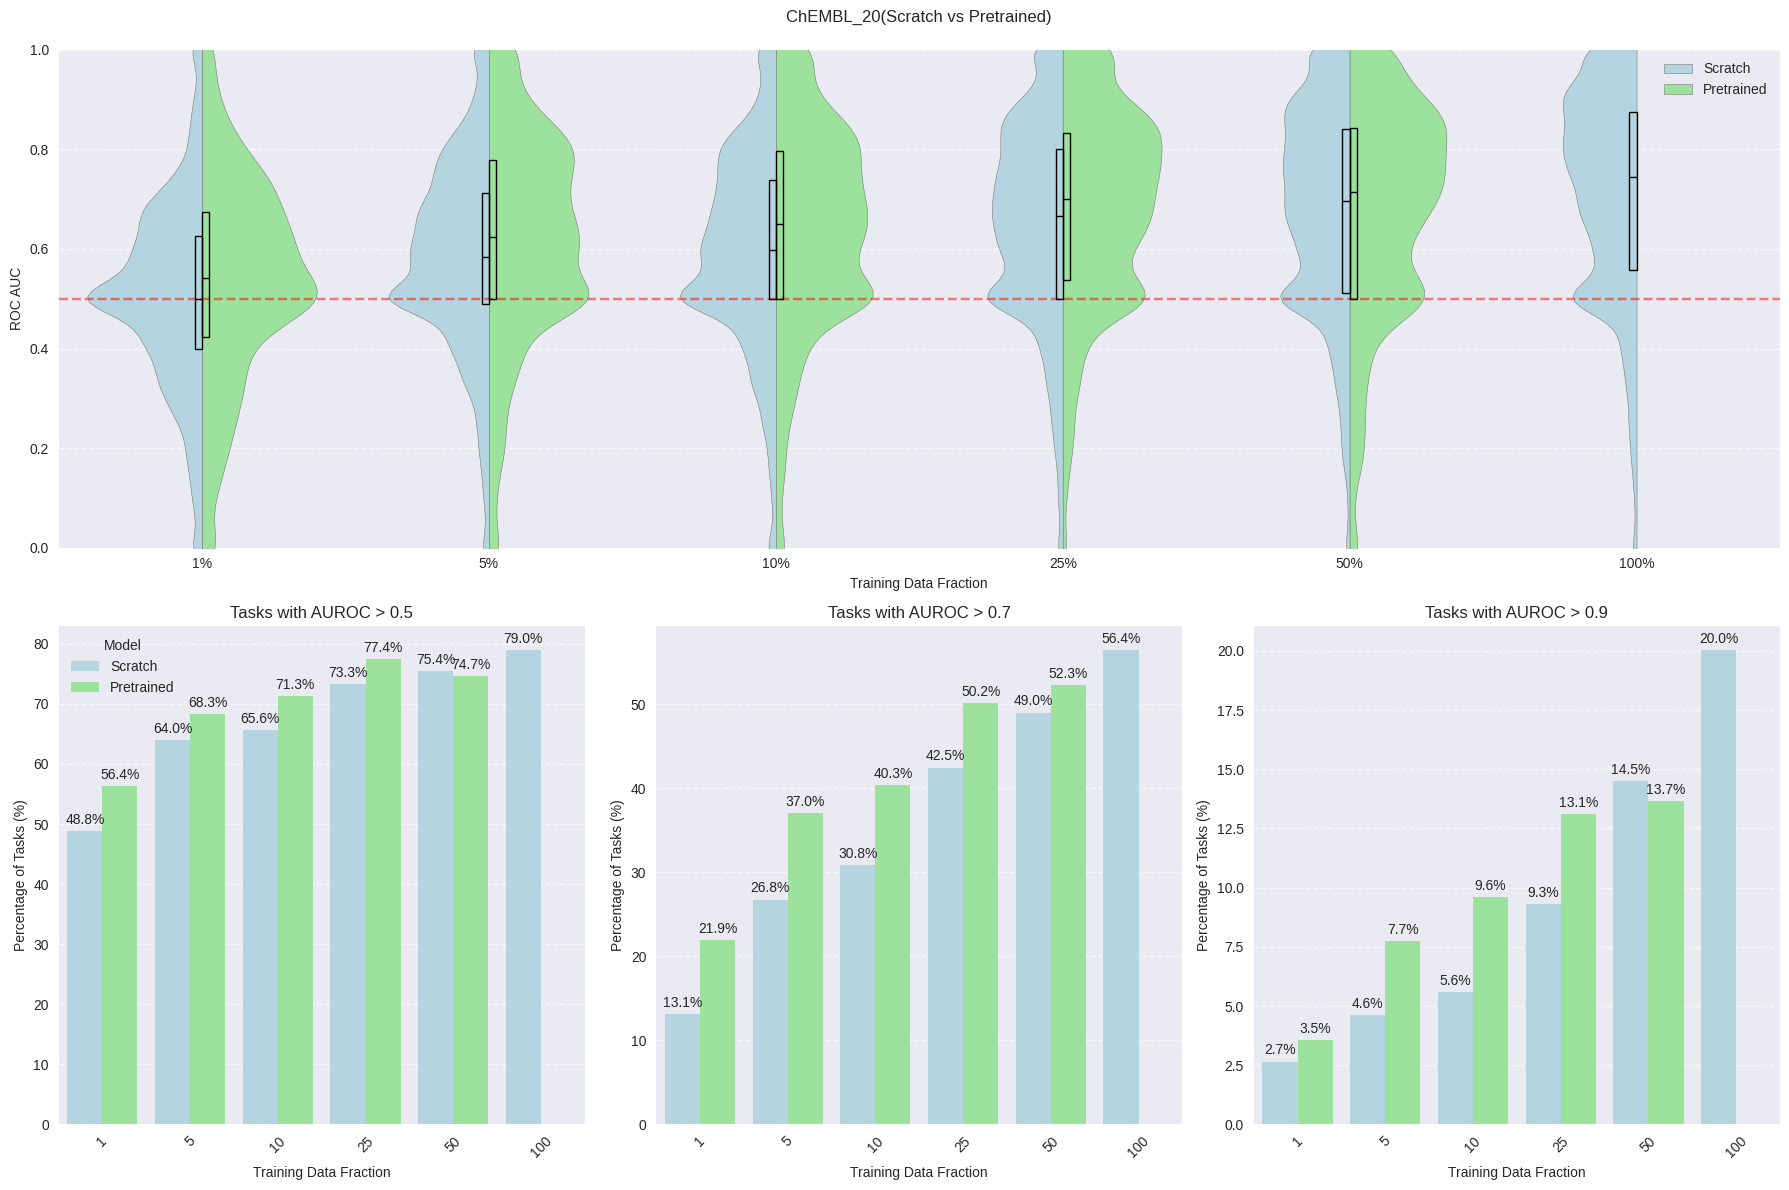

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data for both models
df_model1 = load_data("/scratch/work/masooda1/trained_model_pred/mocop/chembl20_from_scratch/test_results/chembl_20_from_scratch/", "Scratch")
df_model2 = load_data("/scratch/work/masooda1/trained_model_pred/mocop/chembl_20_pretrained_mocop_Aalto_linear_prob/test_results/chembl20_mocop_linear/", "Pretrained")

# Extract AUROC columns
auroc_columns = [f'val/auroc_{i}' for i in range(1310)]

# Get unique fractions
fractions = sorted(df_model1['frac'].unique())

# Prepare data for plotting
plot_data = []

# Process data for both models
for frac in fractions:
    df_model1_frac = df_model1[df_model1['frac'] == frac]
    df_model2_frac = df_model2[df_model2['frac'] == frac]
    
    for model_df, model_name in [(df_model1_frac, 'Scratch'), (df_model2_frac, 'Pretrained')]:
        for _, row_data in model_df.iterrows():
            auroc_values = row_data[auroc_columns].values
            plot_data.extend([{
                'AUROC': val, 
                'Model': model_name, 
                'Fraction': f'{frac}%'
            } for val in auroc_values])

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Set the style
plt.style.use('seaborn')
sns.set_palette("husl")

# Create figure with 2 rows: violin plots and bar plots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3)

# First row: Split violin plot (spanning all columns)
ax1 = fig.add_subplot(gs[0, :])

# Create split violin plot with no inner representation
sns.violinplot(data=plot_df,
               x='Fraction',
               y='AUROC',
               hue='Model',
               split=True,
               inner=None,  # Remove inner box plot
               palette={'Scratch': 'lightblue', 'Pretrained': 'lightgreen'},
               ax=ax1)

# Add customized box plot on top of violin plot
sns.boxplot(data=plot_df,
            x='Fraction',
            y='AUROC',
            hue='Model',
            width=0.05,  # Make boxes narrower
            showfliers=False,  # Don't show outlier points
            ax=ax1,
            medianprops={"color": "black", "linewidth": 1},  # Make median line more visible
            boxprops={"facecolor": "none", "edgecolor": "black"},  # Hollow boxes
            whiskerprops={"visible": False},  # Hide whiskers
            capprops={"visible": False},  # Hide caps
            zorder=3)  # Ensure boxes are drawn on top

# Customize violin plot
ax1.set_title('ChEMBL_20(Scratch vs Pretrained)', pad=20, fontsize=12)
ax1.set_ylabel('ROC AUC', fontsize=10)
ax1.set_xlabel('Training Data Fraction', fontsize=10)
ax1.set_ylim(0, 1)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Remove duplicate legends
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2])

# Second row: Bar plots for different thresholds
thresholds = [0.5, 0.7, 0.9]
for idx, threshold in enumerate(thresholds):
    ax = fig.add_subplot(gs[1, idx])
    
    # Calculate counts for each fraction and model
    counts_data = []
    for frac in fractions:
        for model in ['Scratch', 'Pretrained']:
            mask = (plot_df['Fraction'] == f'{frac}%') & (plot_df['Model'] == model)
            count = (plot_df[mask]['AUROC'] > threshold).sum()
            total = len(plot_df[mask])
            percentage = (count/total) * 100
            counts_data.append({
                'Fraction': frac,
                'Model': model,
                'Percentage': percentage
            })
    
    counts_df = pd.DataFrame(counts_data)
    
    # Create grouped bar plot
    sns.barplot(data=counts_df,
                x='Fraction',
                y='Percentage',
                hue='Model',
                palette={'Scratch': 'lightblue', 'Pretrained': 'lightgreen'},
                ax=ax)
    
    # Customize bar plot
    ax.set_title(f'Tasks with AUROC > {threshold}', fontsize=12)
    ax.set_ylabel('Percentage of Tasks (%)', fontsize=10)
    ax.set_xlabel('Training Data Fraction', fontsize=10)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels if needed
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)
    
    # Remove legend for bar plots except the first one
    if idx > 0:
        ax.get_legend().remove()

# Remove top and right spines from all subplots
for ax in fig.get_axes():
    sns.despine(ax=ax)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('/scratch/work/masooda1/Results/Multimodal/mocop/Chembl_20_ROC_AUC_distribution.png', 
            dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [3]:
#!/usr/bin/env python3
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from typing import List, Tuple, Dict

# Constants
MODEL_NAMES = {
    'scratch': "Scratch",
    'pretrained_2mod': "Pretrained\n(Molecule + Cellpainting)",
    'pretrained_3mod': "Pretrained\n(Molecule + Cellpainting\n+ Gene Expression)"
}

LEGEND_LABELS = [
    "Scratch",
    "Pretrained (Cell painting)",
    "Pretrained (Cell painting + Gene expression)"
]

COLORS = {
    MODEL_NAMES['scratch']: '#1f77b4',      # Dark blue
    MODEL_NAMES['pretrained_2mod']: '#2ca02c',  # Dark green
    MODEL_NAMES['pretrained_3mod']: '#d62728'   # Dark red
}

def create_violin_subplot(ax: plt.Axes, 
                         plot_df: pd.DataFrame, 
                         model1: str, 
                         model2: str, 
                         colors: Dict[str, str]) -> None:
    """
    Create a violin plot with overlaid box plot for a pair of models.
    
    Args:
        ax: Matplotlib axes object
        plot_df: DataFrame containing the plot data
        model1: Name of first model
        model2: Name of second model
        colors: Dictionary mapping model names to colors
    """
    plot_df_subset = plot_df[plot_df['Model'].isin([model1, model2])]
    
    # Create violin plot
    sns.violinplot(data=plot_df_subset,
                  x='Fraction',
                  y='AUROC',
                  hue='Model',
                  split=True,
                  inner=None,
                  palette={model1: colors[model1], model2: colors[model2]},
                  ax=ax)
    
    # Add customized box plot
    sns.boxplot(data=plot_df_subset,
               x='Fraction',
               y='AUROC',
               hue='Model',
               width=0.05,
               showfliers=False,
               ax=ax,
               medianprops={"color": "black", "linewidth": 1},
               boxprops={"facecolor": "none", "edgecolor": "black"},
               whiskerprops={"visible": False},
               capprops={"visible": False},
               zorder=3)
    
    # Customize subplot
    ax.set_ylabel('ROC AUC', fontsize=12)
    ax.set_xlabel('Training Data Fraction', fontsize=12)
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=11)
    ax.get_legend().remove()

def create_threshold_subplot(ax: plt.Axes, 
                           plot_df: pd.DataFrame, 
                           threshold: float, 
                           colors: Dict[str, str]) -> None:
    """
    Create a threshold analysis subplot.
    
    Args:
        ax: Matplotlib axes object
        plot_df: DataFrame containing the plot data
        threshold: Threshold value for AUROC
        colors: Dictionary mapping model names to colors
    """
    # Convert fraction strings to numbers for proper sorting
    fracs = sorted([int(f.rstrip('%')) for f in plot_df['Fraction'].unique()])
    counts_data = []
    
    for frac in fracs:
        frac_str = f'{frac}%'  # Convert back to string format for filtering
        for model in MODEL_NAMES.values():
            mask = (plot_df['Fraction'] == frac_str) & (plot_df['Model'] == model)
            count = (plot_df[mask]['AUROC'] > threshold).sum()
            total = len(plot_df[mask])
            percentage = (count/total) * 100
            counts_data.append({
                'Fraction': frac_str,
                'Model': model,
                'Percentage': percentage
            })
    
    counts_df = pd.DataFrame(counts_data)
    
    # Ensure the order is maintained in the plot by setting the category order
    counts_df['Fraction'] = pd.Categorical(counts_df['Fraction'], 
                                         categories=[f'{f}%' for f in fracs],
                                         ordered=True)
    
    sns.barplot(data=counts_df,
               x='Fraction',
               y='Percentage',
               hue='Model',
               palette=colors,
               ax=ax)
    
    ax.set_title(f'Tasks with AUROC > {threshold}', fontsize=14)
    ax.set_ylabel('Percentage of Tasks (%)', fontsize=12)
    ax.set_xlabel('Training Data Fraction', fontsize=12)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', rotation=90)

def prepare_plot_data(df_model1: pd.DataFrame, 
                     df_model2: pd.DataFrame, 
                     df_model3: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data for plotting.
    
    Args:
        df_model1: DataFrame for scratch model
        df_model2: DataFrame for pretrained 2-mod model
        df_model3: DataFrame for pretrained 3-mod model
    
    Returns:
        DataFrame prepared for plotting
    """
    auroc_columns = [f'val/auroc_{i}' for i in range(1310)]
    fractions = sorted(df_model1['frac'].unique())
    plot_data = []

    for frac in fractions:
        for df, model_key in [
            (df_model1[df_model1['frac'] == frac], 'scratch'),
            (df_model2[df_model2['frac'] == frac], 'pretrained_2mod'),
            (df_model3[df_model3['frac'] == frac], 'pretrained_3mod')
        ]:
            for _, row_data in df.iterrows():
                auroc_values = row_data[auroc_columns].values
                plot_data.extend([{
                    'AUROC': val,
                    'Model': MODEL_NAMES[model_key],
                    'Fraction': f'{frac}%'
                } for val in auroc_values])

    return pd.DataFrame(plot_data)

def plot_distribution_analysis(df_model1: pd.DataFrame, 
                             df_model2: pd.DataFrame, 
                             df_model3: pd.DataFrame, 
                             save_path: str) -> None:
    """
    Create and save distribution analysis plots.
    
    Args:
        df_model1: DataFrame for scratch model
        df_model2: DataFrame for pretrained 2-mod model
        df_model3: DataFrame for pretrained 3-mod model
        save_path: Path to save the plots
    """
    plot_df = prepare_plot_data(df_model1, df_model2, df_model3)
    
    # Set style
    plt.style.use('seaborn')
    
    # Create violin plots
    fig_violin = plt.figure(figsize=(12, 10))
    gs = fig_violin.add_gridspec(3, 1)
    
    comparisons = [
        (MODEL_NAMES['scratch'], MODEL_NAMES['pretrained_2mod']),
        (MODEL_NAMES['scratch'], MODEL_NAMES['pretrained_3mod']),
        (MODEL_NAMES['pretrained_2mod'], MODEL_NAMES['pretrained_3mod'])
    ]
    
    for idx, (model1, model2) in enumerate(comparisons):
        ax = fig_violin.add_subplot(gs[idx])
        create_violin_subplot(ax, plot_df, model1, model2, COLORS)
    
    # Create custom legend
    legend_patches = [
        mpatches.Patch(color=COLORS[MODEL_NAMES['scratch']], label=LEGEND_LABELS[0]),
        mpatches.Patch(color=COLORS[MODEL_NAMES['pretrained_2mod']], label=LEGEND_LABELS[1]),
        mpatches.Patch(color=COLORS[MODEL_NAMES['pretrained_3mod']], label=LEGEND_LABELS[2])
    ]
    
    fig_violin.legend(handles=legend_patches, 
                     loc='upper center', 
                     bbox_to_anchor=(0.5, 1.02), 
                     ncol=3, 
                     fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig_violin)
    
    # Create threshold analysis plots
    fig_threshold = plt.figure(figsize=(12, 10))
    gs_threshold = fig_threshold.add_gridspec(2, 2)
    thresholds = [0.5, 0.7, 0.9]
    
    for idx, threshold in enumerate(thresholds):
        row = idx // 2
        col = idx % 2
        ax = fig_threshold.add_subplot(gs_threshold[row, col])
        create_threshold_subplot(ax, plot_df, threshold, COLORS)
        
        ax.get_legend().remove()
    
    # Add legend in the empty subplot
    legend_ax = fig_threshold.add_subplot(gs_threshold[1, 1])
    legend_ax.axis('off')
    legend_ax.legend(handles=legend_patches, loc='center', fontsize=12)
    
    plt.tight_layout()
    threshold_save_path = save_path.replace('.png', '_threshold_barplot.png')
    plt.savefig(threshold_save_path, dpi=300, bbox_inches='tight')
    plt.close(fig_threshold)

def plot_comparison_bars(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame, save_path: str) -> None:
    """
    Create and save comparison bar plots for AUROC and AUPRC.
    """
    # Combine the data
    df = pd.concat([df1, df2, df3]).dropna()
    
    # Calculate mean values and standard deviations
    mean_values = df.groupby(['frac', 'model'])[['val/auroc_mean', 'val/auprc_mean']].mean().reset_index()
    std_values = df.groupby(['frac', 'model'])[['val/auroc_mean', 'val/auprc_mean']].std().reset_index()
    
    # Set up the plot
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2)
    
    def plot_bars(ax, data, y_col, title, ylabel):
        # Plot bars with error bars
        sns.barplot(data=data,
                   x='frac',
                   y=y_col,
                   hue='model',
                   palette=COLORS,
                   ax=ax,
                   errorbar='sd',
                   capsize=0.05)
        
        # Add value labels below the bars
        for container in ax.containers:
            labels = [f'{v:.3f}' for v in container.datavalues]
            ax.bar_label(container, 
                        labels=labels, 
                        label_type='center',
                        rotation=90)
        
        ax.set_xlabel('Data fraction used for training', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Plot AUROC and AUPRC
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    plot_bars(ax1, df, 'val/auroc_mean', 'AUROC (Chembl_20)', 'AUROC (mean across 1320 tasks)')
    plot_bars(ax2, df, 'val/auprc_mean', 'AUPRC (Chembl_20)', 'Mean AUPRC (mean across 1320 tasks)')
    
    # Add single legend at the top
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), 
              ncol=3, fontsize=12)
    
    # Remove individual legends
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

def plot_comparison_lines(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame, save_path: str) -> None:
    """
    Create and save comparison line plots for AUROC and AUPRC.
    """
    # Combine the data
    df = pd.concat([df1, df2, df3]).dropna()
    
    # Calculate mean values and standard deviations
    mean_values = df.groupby(['frac', 'model'])[['val/auroc_mean', 'val/auprc_mean']].mean().reset_index()
    std_values = df.groupby(['frac', 'model'])[['val/auroc_mean', 'val/auprc_mean']].std().reset_index()
    
    # Set up the plot
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2)
    
    def plot_lines(ax, data, y_col, title, ylabel):
        # Plot lines with error bands
        sns.lineplot(data=data,
                    x='frac',
                    y=y_col,
                    hue='model',
                    palette=COLORS,
                    ax=ax,
                    marker='o',
                    errorbar='se')  # Using 'se' for narrower error bands
        
        # Get unique fractions and set them as x-ticks
        fractions = sorted(data['frac'].unique())
        ax.set_xticks(fractions)
        ax.set_xticklabels([f'{int(f)}%' for f in fractions], rotation=90)
        
        ax.set_xlabel('Data fraction used for training', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Plot AUROC and AUPRC
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    plot_lines(ax1, df, 'val/auroc_mean', 'AUROC (Chembl_20)', 'AUROC (mean across 1320 tasks)')
    plot_lines(ax2, df, 'val/auprc_mean', 'AUPRC (Chembl_20)', 'Mean AUPRC (mean across 1320 tasks)')
    
    # Add single legend at the top
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), 
              ncol=3, fontsize=12)
    
    # Remove individual legends
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

def load_data(results_dir: str, model_name: str) -> pd.DataFrame:
    """
    Load JSON results files and convert them to a DataFrame.
    
    Args:
        results_dir: Directory containing the JSON result files
        model_name: Name of the model to be used in the DataFrame
    
    Returns:
        DataFrame containing the processed results
    """
    all_data = []
    pattern = r"frac(\d+)_split(\d+)_seed(\d+)\.json"
    
    for filename in os.listdir(results_dir):
        if filename.endswith(".json"):
            match = re.match(pattern, filename)
            
            if match:
                frac, split, seed = match.groups()
                with open(os.path.join(results_dir, filename), 'r') as f:
                    data = json.load(f)
                new_data = {
                    'frac': int(frac),
                    'split': int(split),
                    'seed': int(seed),
                    'model': model_name
                }
                new_data.update(data)
                all_data.append(new_data)
    
    return pd.DataFrame(all_data)


In [4]:
"""Main function to execute the analysis and create plots."""
# Define paths
base_dir = "/scratch/cs/pml/AI_drug/trained_model_pred/mocop"
scratch_model_dir = f"{base_dir}/chembl20_from_scratch/test_results/chembl_20_from_scratch/"
pretrained_2mod_dir = f"{base_dir}/chembl_20_pretrained_mocop_Aalto_linear_prob/test_results/chembl20_mocop_linear/"
pretrained_3mod_dir = f"{base_dir}/chembl_20_pretrained_mocop_lincs_linear_prob/test_results/chembl20_mocop_lincs_linear/"
results_dir = "/scratch/work/masooda1/Results/Multimodal/mocop"

# Load data
df_scratch = load_data(scratch_model_dir, "Scratch")
df_pretrained_2mod = load_data(pretrained_2mod_dir, "Pretrained\n(Molecule + Cellpainting)")
df_pretrained_3mod = load_data(pretrained_3mod_dir, "Pretrained\n(Molecule + Cellpainting\n+ Gene Expression)")

# Create plots
plot_comparison_bars(
    df_scratch, 
    df_pretrained_2mod,
    df_pretrained_3mod,
    os.path.join(results_dir, 'Chembl_20_from_scratch_vs_pretrained_barplot.png')
)

plot_distribution_analysis(
    df_scratch, 
    df_pretrained_2mod, 
    df_pretrained_3mod, 
    os.path.join(results_dir, 'Chembl_20_ROC_AUC_distribution.png')
)

# Create line plot
plot_comparison_lines(
    df_scratch, 
    df_pretrained_2mod,
    df_pretrained_3mod,
    os.path.join(results_dir, 'Chembl_20_from_scratch_vs_pretrained_lineplot.png')
)

/tmp/ipykernel_1857322/1899042962.py:184: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
